In [1]:
import itertools

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Saddles

In [2]:
crytical_type_colors_dict = {'min': 'lime', 'max': 'red', 'saddle': 'yellow', 'regular': 'lightgrey'}

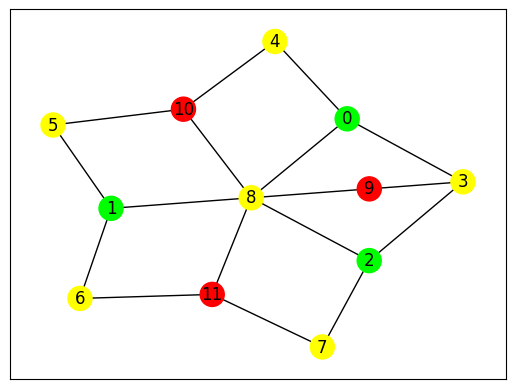

In [3]:
graph0 = nx.MultiGraph()
graph0.add_nodes_from(range(3), critical_type='min')
graph0.add_nodes_from(range(3, 9), critical_type='saddle')
graph0.add_nodes_from(range(9, 12), critical_type='max')

edges = [(0, 3), (0, 4), (0, 8),
         (1, 5), (1, 6), (1, 8),  
         (2, 3), (2, 7), (2, 8),
         (9, 3), (9, 8), 
         (10, 4), (10, 5), (10, 8), 
         (11, 6), (11, 7), (11, 8)
]

for e0, e1 in edges:
    graph0.add_edge(e0, e1, path=[e0, e1])

pos0 = nx.kamada_kawai_layout(graph0)
values0 = np.arange(12)

node_colors0 = pd.DataFrame([data for node, data in graph0.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values

nx.draw_networkx(graph0, node_color=node_colors0, pos=pos0)

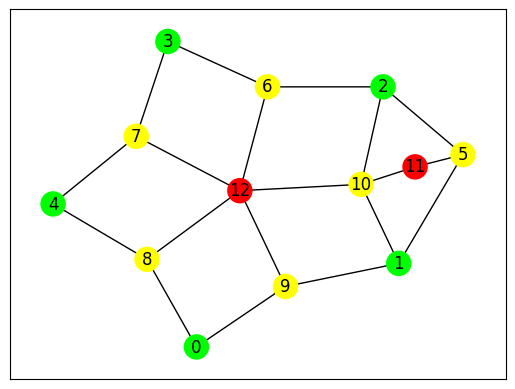

In [4]:
graph1 = nx.MultiGraph()
graph1.add_nodes_from(range(5), critical_type='min')
graph1.add_nodes_from(range(5, 11), critical_type='saddle')
graph1.add_nodes_from(range(11, 13), critical_type='max')

edges = [(0, 8), (0, 9), 
         (1, 5), (1, 9), (1, 10), 
         (2, 5), (2, 6), (2, 10), 
         (3, 6), (3, 7), 
         (4, 7), (4, 8), 
         (5, 11), (10, 11), (10, 12), 
         (6, 12), (7, 12), (8, 12), (9, 12)
]

for e0, e1 in edges:
    graph1.add_edge(e0, e1, path=[e0, e1])

pos1 = nx.kamada_kawai_layout(graph1)
values1 = np.arange(13)
pos1[11] = 0.5*(pos1[10] + pos1[5]) + 0.02*np.random.normal(2)

node_colors1 = pd.DataFrame([data for node, data in graph1.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values

nx.draw_networkx(graph1, node_color=node_colors1, pos=pos1)

## Vis

In [5]:
def point_is_in_triangle(x, y, ax, ay, bx, by, cx, cy, *, include_edges=True, eps=1e-12):
    """
    Returns True if point(s) (x, y) are inside triangle (a, b, c).

    Parameters
    ----------
    x, y : float or array-like
        Point coordinates. Can be scalars or NumPy-broadcastable arrays.
    ax, ay, bx, by, cx, cy : float
        Triangle vertex coordinates.
    include_edges : bool
        If True, points on the boundary count as inside.
        If False, boundary points are excluded.
    eps : float
        Tolerance for numerical stability.

    Returns
    -------
    inside : bool or np.ndarray of bool
        Same broadcasted shape as x and y.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Vectors
    v0x, v0y = cx - ax, cy - ay
    v1x, v1y = bx - ax, by - ay
    v2x, v2y = x - ax,  y - ay

    # Dot products
    dot00 = v0x * v0x + v0y * v0y
    dot01 = v0x * v1x + v0y * v1y
    dot02 = v0x * v2x + v0y * v2y
    dot11 = v1x * v1x + v1y * v1y
    dot12 = v1x * v2x + v1y * v2y

    # Compute barycentric coordinates
    denom = dot00 * dot11 - dot01 * dot01

    # Degenerate triangle (area ~ 0): return all False
    deg = np.abs(denom) <= eps
    # Avoid division by zero warnings while keeping output shape
    denom_safe = np.where(deg, 1.0, denom)

    inv = 1.0 / denom_safe
    u = (dot11 * dot02 - dot01 * dot12) * inv
    v = (dot00 * dot12 - dot01 * dot02) * inv

    if include_edges:
        inside = (u >= -eps) & (v >= -eps) & (u + v <= 1.0 + eps)
    else:
        inside = (u > eps) & (v > eps) & (u + v < 1.0 - eps)

    inside = np.where(deg, False, inside)

    # Return Python bool if inputs were scalar-like
    return bool(inside) if inside.shape == () else inside


In [6]:
class QuadrangulationBasedFunction:
    def __init__(self, graph, values, pos=None):
        """
        """
        self.graph = graph.copy()
        self.values = values.copy()
        if pos is None:
            self.pos = nx.kamada_kawai_layout(self.graph)
        else:
            self.pos = pos
        
    def iterate_quadrangles(self):
        """
        """
        saddles = [node for node, data in self.graph.nodes(data=True) if data['critical_type'] == 'saddle']
        for saddle0, saddle1 in itertools.combinations(saddles, 2):
            crit = set(self.graph.neighbors(saddle0)) & set(self.graph.neighbors(saddle1))
            for node0, node1 in itertools.combinations(crit, 2):
                if set([self.graph.nodes[node]['critical_type'] for node in [node0, node1]]) == {'min', 'max'}:
                    yield saddle0, node0, saddle1, node1

    def iterate_triangles(self):
        """
        """
        for saddle0, node0, saddle1, node1 in self.iterate_quadrangles():
            s0x, s0y = self.pos[saddle0]
            s1x, s1y = self.pos[saddle1]
            n0x, n0y = self.pos[node0]
            n1x, n1y = self.pos[node1]
            cond0 = point_is_in_triangle(n0x, n0y, s0x, s0y, s1x, s1y, n1x, n1y ,include_edges=True)
            cond1 = point_is_in_triangle(n1x, n1y, s0x, s0y, s1x, s1y, n0x, n0y ,include_edges=True)
            if cond0 or cond1:
                yield node0, node1, saddle0
                yield node0, node1, saddle1
            else:
                yield saddle0, saddle1, node0
                yield saddle0, saddle1, node1

    def __call__(self, x, y):
        """
        """
        res = np.nan*np.empty_like(x + y)
        for saddle0, node0, saddle1, node1 in self.iterate_quadrangles():
            p0, p1, p2, p3 = self.pos[saddle0], self.pos[node0], self.pos[saddle1], self.pos[node1]
            v0, v1, v2, v3 = self.values[saddle0], self.values[node0], self.values[saddle1], self.values[node1]
            cx, cy = np.mean([p0, p1, p2, p3], axis=0)
            c_val = 0.5*(v0 + v2)
            for ((ax, ay), a_val), ((bx, by), b_val) in itertools.pairwise(zip([p0, p1, p2, p3, p0], [v0, v1, v2, v3, v0])):
                cond = point_is_in_triangle(x, y, ax, ay, bx, by, cx, cy)
                m = [[ax, ay, 1], [bx, by, 1], [cx, cy, 1]]
                r = [a_val, b_val, c_val]
                if np.linalg.matrix_rank(m) == 3:
                    kx, ky, k0 = np.linalg.solve(m, r)
                    res[cond] = (kx*x + ky*y + k0)[cond]
        return res
    

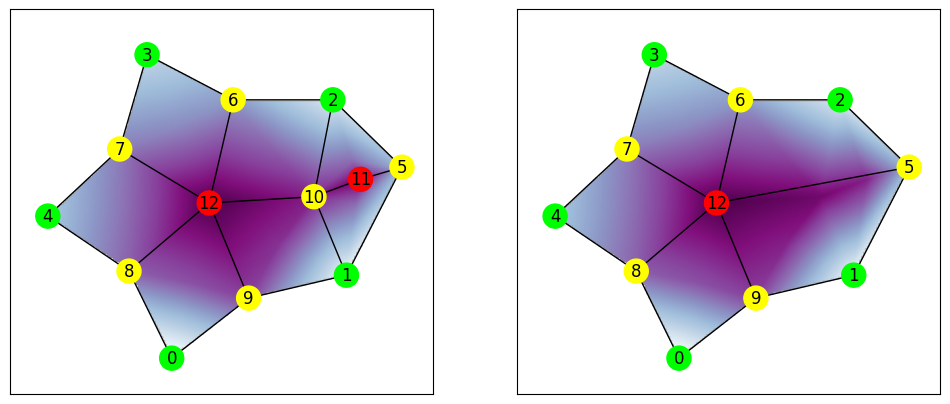

In [22]:
graph1_edited = graph1.copy()
graph1_edited.remove_nodes_from([10,  11])
graph1_edited.add_edge(5, 12)
edited1_node_colors = pd.DataFrame([data for node, data in graph1_edited.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values

values1_edited = values1.copy()
values1_edited[[10, 11]] = values1_edited[[11, 10]]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
x, y = np.meshgrid(*[np.linspace(-1, 1, 201)]*2)

axs[0].imshow(QuadrangulationBasedFunction(graph1, values1, pos1)(x, y), extent=[-1, 1, -1, 1], cmap='BuPu', origin='lower')
nx.draw_networkx(graph1, node_color=node_colors1, pos=pos1, ax=axs[0])

#axs[1].imshow(QuadrangulationBasedFunction(graph1_edited, values1, pos1)(x, y), extent=[-1, 1, -1, 1], cmap='BuPu', origin='lower')
axs[1].imshow(QuadrangulationBasedFunction(graph1, values1_edited, pos1)(x, y), extent=[-1, 1, -1, 1], cmap='BuPu', origin='lower')
nx.draw_networkx(graph1_edited, node_color=edited1_node_colors, pos=pos1, ax=axs[1])

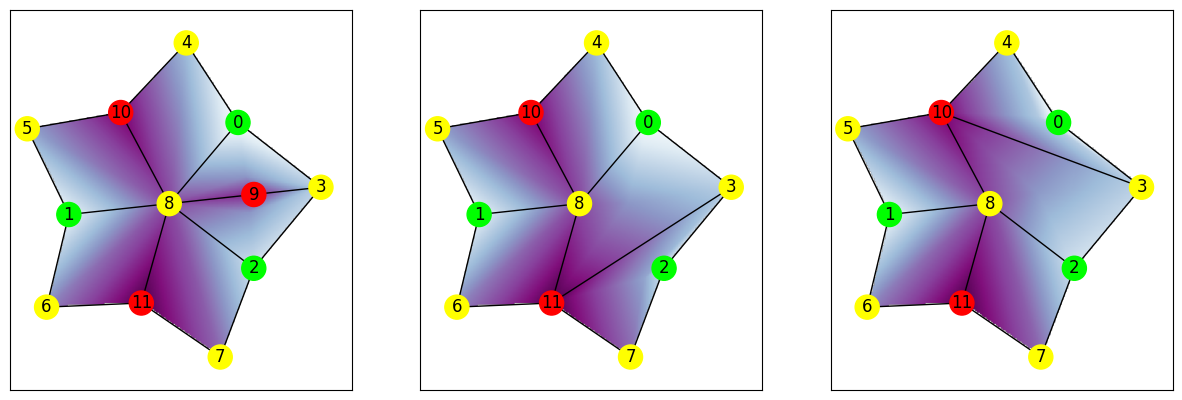

In [14]:
graph0_edited = graph0.copy()
graph0_edited.remove_node(9)
graph0_edited.remove_edge(2, 8)
graph0_edited.add_edge(3, 11)
edited0_node_colors = pd.DataFrame([data for node, data in graph0_edited.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values

graph0_edited1 = graph0.copy()
graph0_edited1.remove_node(9)
graph0_edited1.remove_edge(0, 8)
graph0_edited1.add_edge(3, 10)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
x, y = np.meshgrid(*[np.linspace(-1, 1, 201)]*2)

axs[0].imshow(QuadrangulationBasedFunction(graph0, values0, pos0)(x, y), extent=[-1, 1, -1, 1], cmap='BuPu', origin='lower')
nx.draw_networkx(graph0, node_color=node_colors0, pos=pos0, ax=axs[0])

axs[1].imshow(QuadrangulationBasedFunction(graph0_edited, values0, pos0)(x, y), extent=[-1, 1, -1, 1], cmap='BuPu', origin='lower')
nx.draw_networkx(graph0_edited, node_color=edited0_node_colors, pos=pos0, ax=axs[1])

axs[2].imshow(QuadrangulationBasedFunction(graph0_edited1, values0, pos0)(x, y), extent=[-1, 1, -1, 1], cmap='BuPu', origin='lower')
nx.draw_networkx(graph0_edited1, node_color=edited0_node_colors, pos=pos0, ax=axs[2])

# Saddle Cancellation

Let's $(C_0, C_1)$ be the canceling pair, where $C_1$ is the saddle.

If $C_1$ is not defined, we can find this by $C_1 = \argmin_{C_i\in \text{Neighbors}(C_0)} |f(C_i) - f(C_0)|$

__Input:__ $C_0, C_1$
1. $\{P_0\} = \text{Neighbors}(C_0)/\{C_1\}$
2. $P_1 = \argmax_{P_j\in \text{Neighbors}(C_1)} f(P_j)$
3. $S = \{S_0, S_1\} = (\text{Neighbors}(P_0)\cap\text{Neighbors}(C_1)) \cap \text{Local Mins}$

__Algorithm:__
1. Create a path $P_0-C_0-C_1-P_1$ (or $C_0-C_1-P_1$)
2. Remove Node $C_0$ (with edges $P_0C_0$ and $P_1C_1$)
3. Remove Edges $(S_i, C1)$ for $S_i\in S $ (for default case $S= \{S_0, S_1\}$)
4. If $\text{degree}(C_1) == 1$ remove $C_1$ (saddle is not a monkey saddle)
5. Add an edge $P_0P_1$ with the path atribute $P_0-C_0-C_1-P_1$ (or $C_0-C_1-P_1$)

In [9]:
def iterate_quadrangles(graph):
    saddles = [node for node, data in graph.nodes(data=True) if data['critical_type'] == 'saddle']
    for saddle0, saddle1 in itertools.combinations(saddles, 2):
        crit = set(graph.neighbors(saddle0)) & set(graph.neighbors(saddle1))
        for node_min, node_max in itertools.combinations(crit, 2):
            if set([graph.nodes[node]['critical_type'] for node in [node_min, node_max]]) == {'min', 'max'}:
                if graph.nodes[node_min]['critical_type'] == 'max':
                    node_min, node_max = node_max, node_min
                yield saddle0, node_min, saddle1, node_max

In [10]:
def get_neighbouring_quadrangles(graph, e0, e1):
    """
    """
    pass

In [ ]:
def make_cancellation(graph: nx.MultiGraph, values, node0, node1=None):
    """
    Makes the cancellation of birth-death pair in the paths graph.

    Pramaters:
    ----------
    graph: nx.MultiGraph
        Multigraph
        Nodes should have 'critical_type' attribute with values: 'max', 'min' or 'saddle'.
        This function should be sed in the mothod MorseSmale.get_paths_graph, and also applyable to the resulting graph.

    values: array

    node0: int
        The index of the canceling vertex.
        This expect to be local maxima or minima and the coresponding node in the graph expect to have degree 1 or 2.

    node1: int
        The index of the saddle, paired with canceling vertex

    """
    if (graph.degree(node0) not in [1, 2]) or (graph.nodes[node0].get('critical_type') not in ['min', 'max']):
        raise ValueError('node0 expect to be an index of local maxima or minima degree 1 or 2.')
    
    # define a paired saddle
    if node1 is None:
        neighbors = list(graph.neighbors(node0))
        neighbors_vals = np.array([values[node] for node in neighbors])
        node1 = neighbors[np.argmin(abs(neighbors_vals - values[node0]))]

    # check if it is saddle
    if graph.nodes[node1].get('critical_type') != 'saddle':
        raise ValueError('node1 expect to be an index of saddle')
    
    # the case of isolated critical point
    if graph.degree(node0) == 1:
        pass


    if graph.degree(node0) == 2:
        pass